# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку.

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [2]:
import os
import json
import pandas as pd
import datetime
import re
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score


/tmp/ipykernel_11302/1437677284.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные*
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр


> *Сырые данные не получилось загрузить в github, поэтому они доступны для скачивания по ссылке: https://www.kaggle.com/competitions/copy-of-23-24-ml/data.

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [4]:
PATH_TO_DATA = "../data/"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA,
                                             "train_data.csv"),
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA,
                                            "train_targets.csv"),
                                   index_col="match_id_hash")

In [5]:
df_train_features.shape

(31698, 245)

In [6]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [7]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [8]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.3,
                                                      random_state=SEED)

#### Обучим случайный лес

In [10]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: user 1min 28s, sys: 519 ms, total: 1min 28s
Wall time: 7.08 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [11]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [12]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [13]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [14]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"),
                                   index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred},
                                 index=df_test_features.index)

In [15]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
# df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2024-04-03_11-20-39.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [16]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [17]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 6min 56s, sys: 2.09 s, total: 6min 58s
Wall time: 30.5 s


In [18]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [19]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [20]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()

    # переведем JSON в питоновский словарь
    match = json.loads(line)

In [22]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center> $KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [23]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

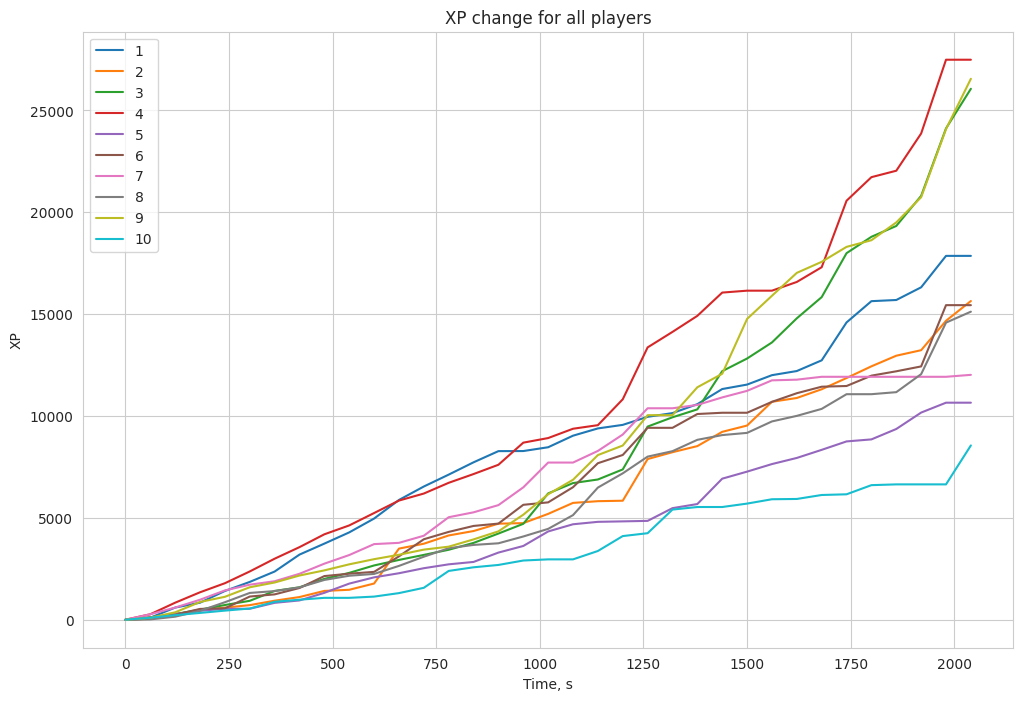

In [24]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [25]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")

try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")


def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными

    Результат
    ---------
    Возвращает записи о каждом матче
    """

    if n_matches_to_read is None:
        n_matches_to_read = total_matches

    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [26]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными

    Результат
    ---------
    Добавляет новые признаки в таблицу
    """

    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills

        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [27]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended,
                 os.path.join(PATH_TO_DATA,
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [28]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.25,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.50,0,0,3,0,0.0,1.0,-1.0


In [29]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 388 ms, sys: 825 ms, total: 1.21 s
Wall time: 1min 4s


In [30]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

## Попробуем улучшить модель

Начнем с небольшого EDA. Сперва проверим сбалансированость таргетной переменной.

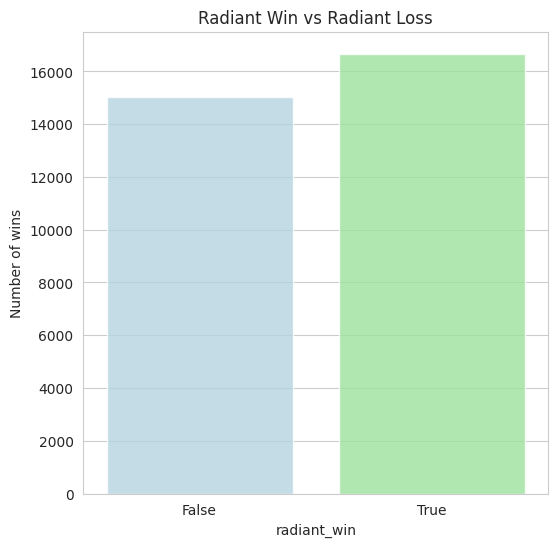

In [31]:
plt.figure(figsize=(6, 6))
sns.countplot(data = df_train_targets, x = 'radiant_win', alpha =.80, palette= ['lightblue','lightgreen'])
plt.title('Radiant Win vs Radiant Loss')
plt.ylabel('Number of wins')
plt.show()

Таргетная переменная сбалансирована. Теперь посмотрим, какие вообще фичи есть в исходных данных:

In [52]:
features = [feature for feature in df_train_features_extended.columns]
features

['game_time',
 'game_mode',
 'lobby_type',
 'objectives_len',
 'chat_len',
 'r1_hero_id',
 'r1_kills',
 'r1_deaths',
 'r1_assists',
 'r1_denies',
 'r1_gold',
 'r1_lh',
 'r1_xp',
 'r1_health',
 'r1_max_health',
 'r1_max_mana',
 'r1_level',
 'r1_x',
 'r1_y',
 'r1_stuns',
 'r1_creeps_stacked',
 'r1_camps_stacked',
 'r1_rune_pickups',
 'r1_firstblood_claimed',
 'r1_teamfight_participation',
 'r1_towers_killed',
 'r1_roshans_killed',
 'r1_obs_placed',
 'r1_sen_placed',
 'r2_hero_id',
 'r2_kills',
 'r2_deaths',
 'r2_assists',
 'r2_denies',
 'r2_gold',
 'r2_lh',
 'r2_xp',
 'r2_health',
 'r2_max_health',
 'r2_max_mana',
 'r2_level',
 'r2_x',
 'r2_y',
 'r2_stuns',
 'r2_creeps_stacked',
 'r2_camps_stacked',
 'r2_rune_pickups',
 'r2_firstblood_claimed',
 'r2_teamfight_participation',
 'r2_towers_killed',
 'r2_roshans_killed',
 'r2_obs_placed',
 'r2_sen_placed',
 'r3_hero_id',
 'r3_kills',
 'r3_deaths',
 'r3_assists',
 'r3_denies',
 'r3_gold',
 'r3_lh',
 'r3_xp',
 'r3_health',
 'r3_max_health',
 '

Видим, что почти все переменные рассчитаны **отдельно для каждого героя**, мы же можем рассчитать **суммарные показатели** по всем героям в каждой команде - так будет удобнее на проследить взаимосвязь между победой Radiant и отдельными признаками при визуализации.

In [33]:
df = df_train_features_extended.copy()

In [34]:
# Добавляем суммарные показатели по командам
selected_features = ['xp', 'gold', 'lh', 'kills', 'denies', 'assists', 'stuns', 'level', 'health']
for feature in selected_features:
    df[f'radiant_{feature}_total'] = df[re.findall(fr"r\d_{feature}", ' '.join(features))].sum(axis=1)
    df[f'dire_{feature}_total'] = df[re.findall(fr"d\d_{feature}", ' '.join(features))].sum(axis=1)

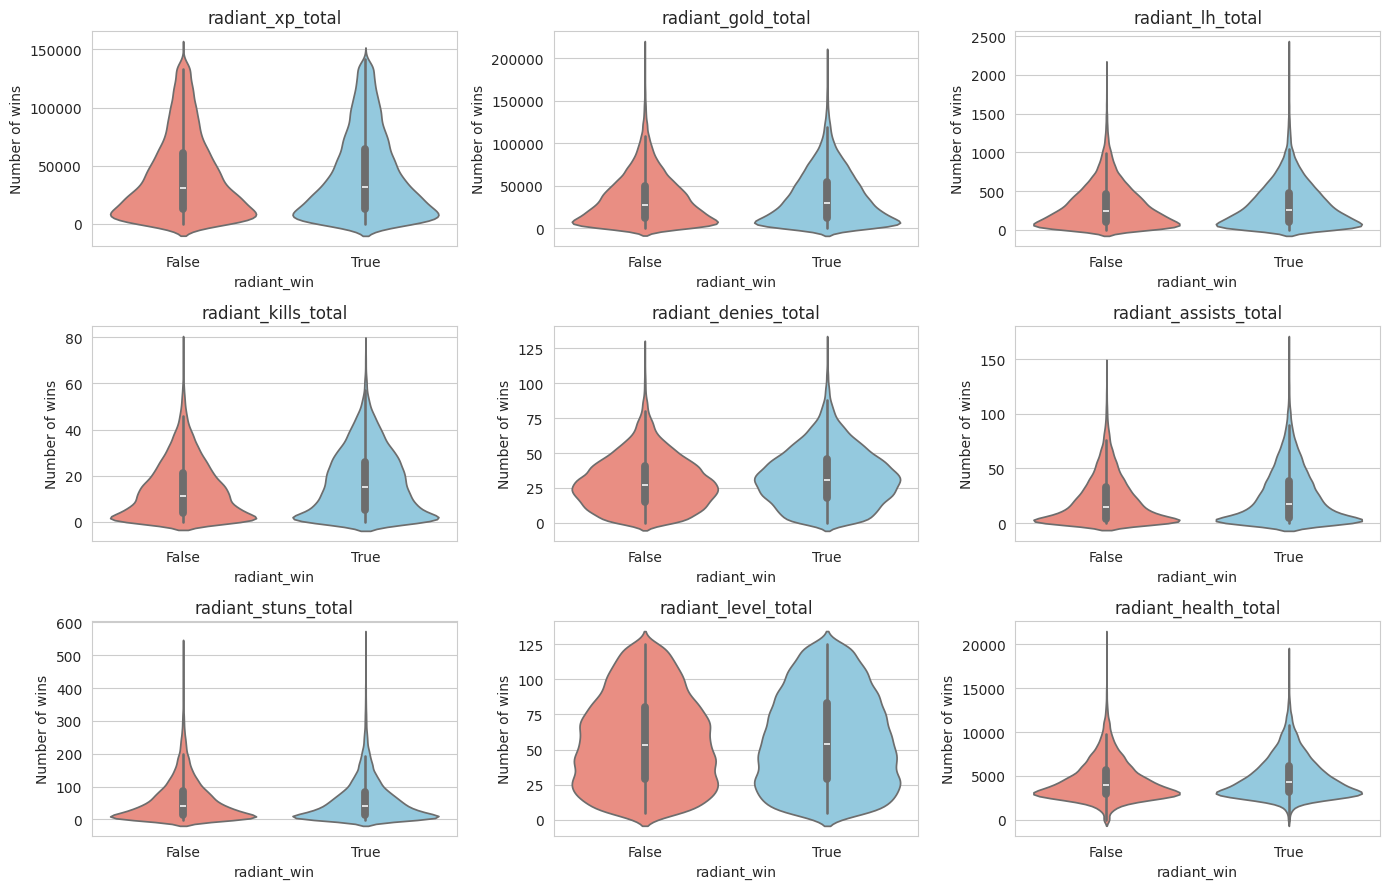

In [35]:
df['radiant_win'] = df_train_targets['radiant_win']
columns_to_plot = re.findall(r"radiant_[\w]+_total", ' '.join(df.columns))

plt.figure(figsize=(14, 9))
for i, col in enumerate(columns_to_plot):
    plt.subplot(3, 3, i + 1)
    sns.violinplot(data = df, x = 'radiant_win', y = col, palette= ['salmon','skyblue'])
    plt.title(col)
    plt.ylabel('Number of wins')
plt.tight_layout()
plt.show()

По признакам, отражающим некоторые суммарные показатели по команде Radiant, **почти незаметна** разница между матчами, в которых Radiant одержала победу и матчами, в которых проиграла. Тем не менее, попробуем добавить суммарные показатели в модель, но закодируем их по-другому: так как нас интересует победа команды Radiant, можем посчитать **разницу в суммарных показателях** между командами Radiant и Dire.

In [36]:
# Добавляем разницу в суммарных показателях между командами
for feature in selected_features:
    df[f'radiant_dire_{feature}_dif'] = df[f'radiant_{feature}_total'] - df[f'dire_{feature}_total'] 
    df = df.drop(columns=[f'radiant_{feature}_total', f'dire_{feature}_total'])
df

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,radiant_win,radiant_dire_xp_dif,radiant_dire_gold_dif,radiant_dire_lh_dif,radiant_dire_kills_dif,radiant_dire_denies_dif,radiant_dire_assists_dif,radiant_dire_stuns_dif,radiant_dire_level_dif,radiant_dire_health_dif
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,True,4641,5028,31,13,12,11,38.527789,7,1188
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,True,0,400,0,0,0,0,0.000000,0,-18
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,False,429,1104,-1,0,4,0,7.231550,1,1089
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,True,-1225,2831,50,-2,-5,-1,14.696284,-1,56
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,False,-554,-790,30,-4,-7,-3,-40.684134,0,217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,99,9,11,9,3,...,False,-10136,-13706,86,-7,10,-27,-131.876147,-6,-8754
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,22,3,9,14,3,...,True,18717,12231,172,8,-5,22,-33.316521,12,-3854
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,1,1,2,1,0,...,True,-4359,-4448,-38,-12,-3,-16,-34.225366,-5,-2215


Посчитаем ROC-AUC на кросс-валидации на данных с новыми признаками:

In [37]:
df = df.drop(columns=['radiant_win'])
cv_scores_extended_1 = cross_val_score(rf_model, df.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации до добавления признаков: {cv_scores_extended.mean()}")
print(f"ROC-AUC на кросс-валидации после добавления признаков:: {cv_scores_extended_1.mean()}")

ROC-AUC на кросс-валидации до добавления признаков: 0.778796825263235
ROC-AUC на кросс-валидации после добавления признаков:: 0.8138259907960904


Теперь попробуем получить из исходных данных информацию о том, выбор каких героев чаще всего приносил комадам победу.

Переведем данные о победе в матчах и используемых героях в удобный для дальнейшего анализа длинный вид:

In [38]:
df['radiant_win'] = df_train_targets['radiant_win']
win_rate = df.melt('radiant_win', value_vars=['r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id','r5_hero_id', 
      'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id'])
win_rate

,radiant_win,variable,value
0,True,r1_hero_id,15
1,True,r1_hero_id,101
2,False,r1_hero_id,57
3,True,r1_hero_id,119
4,False,r1_hero_id,12
...,...,...,...
316975,False,d5_hero_id,102
316976,True,d5_hero_id,31
316977,True,d5_hero_id,97
316978,True,d5_hero_id,73


Сначала посчитаем, в скольких матчах участвовал тот или иной герой.

In [39]:
total_matches = win_rate.value.value_counts().to_frame()
total_matches

,count
value,
14,13207
11,9187
32,7628
8,7270
74,6392
...,...
82,648
65,585
80,583


Теперь посчитаем, в скольких матчах выигрывал тот или иной герой, отдельно для команды Radiant (`radiant_win == True`), и отдельно - для команды Dire (`radiant_win == False`).

In [40]:
radiant_winrate = win_rate.query('(variable == "r1_hero_id" | variable == "r2_hero_id" | variable == "r3_hero_id" | variable == "r4_hero_id" | variable == "r5_hero_id") & radiant_win == True').value.value_counts().to_frame()
radiant_winrate

,count
value,
14,3537
11,2369
32,2205
8,1992
74,1664
...,...
82,147
65,145
80,138


In [41]:
dire_winrate = win_rate.query('(variable == "d1_hero_id" | variable == "d2_hero_id" | variable == "d3_hero_id" | variable == "d4_hero_id" | variable == "d5_hero_id") & radiant_win == False').value.value_counts().to_frame()
dire_winrate

,count
value,
14,3122
32,2210
11,1983
8,1796
74,1501
...,...
82,131
65,127
80,118


Составим итоговую таблицу с коэффициентом выигрыша для каждого героя (`hero_winrate`), расчитанного как частное количества победных матчей (как в составе **Radiant**, так и **Dire**) на количество всех матчей с участием этого героя.

In [42]:
win_rate_df = pd.merge(radiant_winrate, dire_winrate, left_index=True, right_index=True, suffixes=('_wins_radiant', '_wins_dire'))
win_rate_df['total_wins'] = win_rate_df['count_wins_radiant'] + win_rate_df['count_wins_dire']
win_rate_df = win_rate_df.join(total_matches).rename(columns={"count": "total_matches"})
win_rate_df['hero_winrate'] = win_rate_df['total_wins'] / win_rate_df['total_matches']
win_rate_df = win_rate_df.reset_index().rename(columns={"value": "hero_id"})
win_rate_df.sort_values(by=['hero_winrate'], ascending=False)

,hero_id,count_wins_radiant,count_wins_dire,total_wins,total_matches,hero_winrate
88,92,353,349,702,1166,0.602058
2,32,2205,2210,4415,7628,0.578789
57,67,614,525,1139,1972,0.577586
10,22,1305,1168,2473,4318,0.572719
53,20,651,625,1276,2301,0.554542
...,...,...,...,...,...,...
100,13,283,274,557,1305,0.426820
80,46,414,391,805,1934,0.416236
59,19,611,520,1131,2737,0.413226
99,73,285,255,540,1333,0.405101


Теперь добавим признак `winrate` для каждого героя в командах **Radiant** и **Dire** в исходных данных.

In [43]:
win_rate_df = win_rate_df[['hero_id', 'hero_winrate']]
df= df.drop(columns=['radiant_win'])
df_extended = df.copy()
for i in range(1,6):
    df_extended = pd.merge(df_extended, win_rate_df, left_on=f'r{i}_hero_id', right_on='hero_id')
    df_extended.rename(columns={'hero_winrate': f'r{i}_winrate'}, inplace=True)
    df_extended.drop(columns=['hero_id'], inplace=True)
    df_extended = pd.merge(df_extended, win_rate_df, left_on=f'd{i}_hero_id', right_on='hero_id')
    df_extended.rename(columns={'hero_winrate': f'd{i}_winrate'}, inplace=True)
    df_extended.drop(columns=['hero_id'], inplace=True)
df_extended

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,r1_winrate,d1_winrate,r2_winrate,d2_winrate,r3_winrate,d3_winrate,r4_winrate,d4_winrate,r5_winrate,d5_winrate
0,658,4,0,3,10,15,7,2,0,7,...,0.479358,0.473636,0.545319,0.504202,0.528971,0.472848,0.503371,0.536993,0.474359,0.602058
1,21,23,0,0,0,101,0,0,0,0,...,0.522029,0.507140,0.527214,0.577586,0.491272,0.515546,0.518550,0.489277,0.445614,0.497717
2,160,22,7,0,0,57,0,0,0,1,...,0.532962,0.521183,0.466926,0.532309,0.541269,0.497850,0.447745,0.552333,0.503966,0.521045
3,1016,22,0,1,0,119,0,3,3,5,...,0.503966,0.515546,0.517799,0.447745,0.491272,0.488838,0.497302,0.478618,0.550531,0.467043
4,582,22,7,2,2,12,3,1,2,9,...,0.505334,0.527214,0.518550,0.515546,0.400759,0.521183,0.483508,0.503966,0.485303,0.532309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31693,2666,22,0,23,8,99,9,11,9,3,...,0.530687,0.504202,0.467043,0.468254,0.489277,0.497717,0.577586,0.521183,0.443043,0.552333
31694,2525,22,0,15,5,22,3,9,14,3,...,0.572719,0.461486,0.503371,0.495822,0.545796,0.527214,0.490237,0.413226,0.578789,0.530361
31695,1002,4,0,4,0,1,1,2,1,0,...,0.472848,0.506567,0.505334,0.503966,0.515546,0.530687,0.545796,0.523574,0.435476,0.451797
31696,377,22,7,1,0,14,0,2,1,1,...,0.504202,0.485119,0.439108,0.515546,0.505334,0.473713,0.510832,0.528971,0.503371,0.405101


И объединим все `winrate's` в одну переменную аналогично с тем, как делали выше: посчитаем разницу между средними (тут уже не суммами) `winrate's` для героев команд Radiant и Dire.

In [44]:
df_extended['radiant_dire_winrate_dif'] = df_extended[re.findall(fr"r\d_winrate", ' '.join(df_extended.columns))].mean(axis=1) - df_extended[re.findall(fr"d\d_winrate", ' '.join(df_extended.columns))].mean(axis=1)
df_extended

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d1_winrate,r2_winrate,d2_winrate,r3_winrate,d3_winrate,r4_winrate,d4_winrate,r5_winrate,d5_winrate,radiant_dire_winrate_dif
0,658,4,0,3,10,15,7,2,0,7,...,0.473636,0.545319,0.504202,0.528971,0.472848,0.503371,0.536993,0.474359,0.602058,-0.011672
1,21,23,0,0,0,101,0,0,0,0,...,0.507140,0.527214,0.577586,0.491272,0.515546,0.518550,0.489277,0.445614,0.497717,-0.016517
2,160,22,7,0,0,57,0,0,0,1,...,0.521183,0.466926,0.532309,0.541269,0.497850,0.447745,0.552333,0.503966,0.521045,-0.026370
3,1016,22,0,1,0,119,0,3,3,5,...,0.515546,0.517799,0.447745,0.491272,0.488838,0.497302,0.478618,0.550531,0.467043,0.032616
4,582,22,7,2,2,12,3,1,2,9,...,0.527214,0.518550,0.515546,0.400759,0.521183,0.483508,0.503966,0.485303,0.532309,-0.041353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31693,2666,22,0,23,8,99,9,11,9,3,...,0.504202,0.467043,0.468254,0.489277,0.497717,0.577586,0.521183,0.443043,0.552333,-0.007210
31694,2525,22,0,15,5,22,3,9,14,3,...,0.461486,0.503371,0.495822,0.545796,0.527214,0.490237,0.413226,0.578789,0.530361,0.052561
31695,1002,4,0,4,0,1,1,2,1,0,...,0.506567,0.505334,0.503966,0.515546,0.530687,0.545796,0.523574,0.435476,0.451797,-0.008318
31696,377,22,7,1,0,14,0,2,1,1,...,0.485119,0.439108,0.515546,0.505334,0.473713,0.510832,0.528971,0.503371,0.405101,0.010880


Вновь посчитаем ROC-AUC на кросс-валидации на данных после добавления новых признаков:

In [45]:
cv_scores_extended_2 = cross_val_score(rf_model, df_extended.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации до добавления признаков: {cv_scores_extended_1.mean()}")
print(f"ROC-AUC на кросс-валидации после добавления признаков: {cv_scores_extended_2.mean()}")

ROC-AUC на кросс-валидации до добавления признаков: 0.8138259907960904
ROC-AUC на кросс-валидации после добавления признаков: 0.8225058491488321


## Бустинг

До этого мы работали только с данными, добавляя новые признаки, теперь же попробуем улучшить модель с помощью бустинга и подбора гиперпараметров. Будем использовать `xgboost.XGBRFClassifier` из библиотеки xgboost.

In [49]:
# Подберем гиперпараметры с помощью GridSearchCV
params = {'n_estimators': [50,100],
          'learning_rate': [0.1, 0.01, 0.001], 
          'max_depth': range(5,20,5)
         }
xgbrf_clf = xgboost.XGBRFClassifier(nthread=8, seed=SEED)
grid_search_xgbrf_clf = GridSearchCV(xgbrf_clf, params, cv=cv, scoring='roc_auc')
grid_search_xgbrf_clf.fit(df_extended.values, y)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10801, test_size=0.3, train_size=None),
             estimator=XGBRFClassifier(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bytree=None, device=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=N...
                                       max_delta_step=None, max_depth=None,
                                       max_leaves=None, min_child_weight=None,
                                       missing=nan, monotone_constraints=None,
                                       multi_strategy=None, n_estimators=None,
                                       n_jobs=None, nthread=8,
                                       num_parallel_tree=None,
                                       objective='binary:logistic',
                                       random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': range(5, 20, 5),
                         'n_estimators': [50, 100]},
             scoring='roc_auc')

In [50]:
final_xgbrf_model = grid_search_xgbrf_clf.best_estimator_
final_xgbrf_model

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.1, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=10, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=100, n_jobs=None, nthread=8,
                num_parallel_tree=None, objective='binary:logistic', ...)

Проверим, повысился ли ROC-AUC

In [51]:
cv_scores_extended_3 = cross_val_score(final_xgbrf_model, df_extended.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для модели RandomForestClassifier: {cv_scores_extended_2.mean()}")
print(f"ROC-AUC на кросс-валидации для модели XGBRFClassifier: {cv_scores_extended_3.mean()}")

ROC-AUC на кросс-валидации для модели RandomForestClassifier: 0.8225058491488321
ROC-AUC на кросс-валидации для модели XGBRFClassifier: 0.8315957193618381


## Создаем посылку

Напишем функцию, чтобы добавлять новые признаки в тестовые данные.

In [54]:
def add_new_features(df_features, win_rate_df, matches_file):
    
    # Добавляем признаки (tower_kills)
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills

    # Добавляем признаки (radiant_dire_dif по некоторым показателям)
    selected_features = ['xp', 'gold', 'lh', 'kills', 'denies', 'assists', 'stuns', 'level', 'health']
    for feature in selected_features:
        df_features[f'radiant_dire_{feature}_dif'] = df_features[re.findall(fr"r\d_{feature}", ' '.join(df_features.columns))].sum(axis=1) - df_features[re.findall(fr"d\d_{feature}", ' '.join(df_features.columns))].sum(axis=1)

    # Добавляем признаки (hero winrate)
    for i in range(1,6):
        df_features = pd.merge(df_features, win_rate_df, left_on=f'r{i}_hero_id', right_on='hero_id')
        df_features.rename(columns={'hero_winrate': f'r{i}_winrate'}, inplace=True)
        df_features.drop(columns=['hero_id'], inplace=True)
        df_features = pd.merge(df_features, win_rate_df, left_on=f'd{i}_hero_id', right_on='hero_id')
        df_features.rename(columns={'hero_winrate': f'd{i}_winrate'}, inplace=True)
        df_features.drop(columns=['hero_id'], inplace=True)

    df_features['radiant_dire_winrate_dif'] = df_features[re.findall(fr"r\d_winrate", ' '.join(df_features.columns))].mean(axis=1) - df_features[re.findall(fr"d\d_winrate", ' '.join(df_features.columns))].mean(axis=1)

    return df_features
        

In [55]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"),
                                   index_col="match_id_hash")
df_test_features_extended = add_new_features(df_test_features, win_rate_df, os.path.join(PATH_TO_DATA,"test_raw_data.jsonl"))
df_test_features_extended

  0%|          | 0/31698 [00:00<?, ?it/s]

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d1_winrate,r2_winrate,d2_winrate,r3_winrate,d3_winrate,r4_winrate,d4_winrate,r5_winrate,d5_winrate,radiant_dire_winrate_dif
0,155,22,7,1,11,11,0,0,0,0,...,0.505334,0.516029,0.490237,0.504202,0.497850,0.495822,0.523227,0.483380,0.486572,-0.006015
1,576,22,7,1,4,14,1,0,3,1,...,0.507140,0.530687,0.447745,0.522029,0.521045,0.488838,0.520068,0.506567,0.468254,0.017614
2,453,22,7,1,3,42,0,1,1,0,...,0.485475,0.520068,0.572719,0.528971,0.497302,0.478618,0.443043,0.464957,0.472848,0.013405
3,721,4,0,2,1,30,2,2,1,3,...,0.461486,0.487390,0.550531,0.486572,0.465463,0.468254,0.532309,0.478618,0.493662,-0.015570
4,752,22,7,1,0,8,2,0,2,8,...,0.467043,0.528893,0.515723,0.578789,0.550531,0.504202,0.515546,0.478618,0.487390,0.015063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7972,509,4,0,1,0,16,2,0,0,1,...,0.572719,0.498474,0.493662,0.507140,0.521183,0.451797,0.523574,0.478618,0.529869,-0.046576
7973,2561,22,7,17,7,76,2,9,1,6,...,0.500673,0.478618,0.528971,0.483508,0.506236,0.491272,0.416236,0.530687,0.488838,0.014405
7974,1783,22,0,8,23,3,1,9,9,0,...,0.504202,0.518550,0.506236,0.480507,0.578789,0.495150,0.521045,0.503371,0.518589,-0.024090
7975,2405,22,7,12,4,22,3,8,14,7,...,0.488838,0.578789,0.445614,0.541269,0.466926,0.400759,0.545796,0.485475,0.473713,0.031625


In [56]:
# После merge при добавлении признаков исчез исходный индекс - вернем его 
df_test_features_extended['match_id_hash'] = df_test_features.index
df_test_features_extended = df_test_features_extended.set_index('match_id_hash')
df_test_features_extended

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d1_winrate,r2_winrate,d2_winrate,r3_winrate,d3_winrate,r4_winrate,d4_winrate,r5_winrate,d5_winrate,radiant_dire_winrate_dif
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0.505334,0.516029,0.490237,0.504202,0.497850,0.495822,0.523227,0.483380,0.486572,-0.006015
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,0.507140,0.530687,0.447745,0.522029,0.521045,0.488838,0.520068,0.506567,0.468254,0.017614
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,0.485475,0.520068,0.572719,0.528971,0.497302,0.478618,0.443043,0.464957,0.472848,0.013405
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,30,2,2,1,3,...,0.461486,0.487390,0.550531,0.486572,0.465463,0.468254,0.532309,0.478618,0.493662,-0.015570
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,8,2,0,2,8,...,0.467043,0.528893,0.515723,0.578789,0.550531,0.504202,0.515546,0.478618,0.487390,0.015063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,4,0,1,0,16,2,0,0,1,...,0.572719,0.498474,0.493662,0.507140,0.521183,0.451797,0.523574,0.478618,0.529869,-0.046576
06e2b42495855647830ccc6d466f913c,2561,22,7,17,7,76,2,9,1,6,...,0.500673,0.478618,0.528971,0.483508,0.506236,0.491272,0.416236,0.530687,0.488838,0.014405
defd0caeed6ea83d7d5fbdec013fe7d1,1783,22,0,8,23,3,1,9,9,0,...,0.504202,0.518550,0.506236,0.480507,0.578789,0.495150,0.521045,0.503371,0.518589,-0.024090


In [58]:
X_train = df_extended.values
y_train = df_train_targets["radiant_win"].values.astype("int8")

final_xgbrf_model.fit(X_train, y_train)

X_test = df_test_features_extended.values
y_test_pred = final_xgbrf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred},
                                 index=df_test_features.index)

In [ ]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2024-04-03_00-36-49.csv
